In [1]:
import numpy as np
import pandas as pd
import sys
import os

import matplotlib
import matplotlib.pyplot as plt

import sklearn.metrics
from sklearn.metrics import roc_auc_score, roc_curve
from joblib import Parallel, delayed
from sklearn.utils import resample

import scipy.stats

sys.path.append("/home/icb/sergey.vilov/workspace/MLM/utils") 

import misc

from misc import model_colors

%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.jp-OutputArea-output {display:flex}</style>"))

In [3]:
data_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/mlm/'

# Compute AUC

for each split, compute AUC and get confidence intervals via bootstrapping

In [4]:
models = ['DNABERT','DNBT-3UTR-RNA','DNABERT2','DNABERT2-ZOO','DNBT2-3UTR-RNA','NT-MS-v2-100M',
         'NT-3UTR-RNA','STSP-3UTR-RNA','STSP-3UTR-RNA-SA','STSP-3UTR-RNA-HS','STSP-3UTR-DNA',
          'PhyloP-100way', 'PhyloP-241way','CADD','Zoo-AL']

In [5]:
utr_variants = pd.read_csv(data_dir + 'all_scores/variant_scores.tsv.gz', sep='\t')

utr_variants.groupby('split').label.value_counts()

split       label
CADD        0.0      10000
            1.0      10000
clinvar     0.0      10000
            1.0        261
eQTL-susie  0.0      10000
            1.0      10000
gnomAD      0.0      10000
            1.0      10000
Name: count, dtype: int64

In [6]:
scores = ['pref','palt_inv','pratio','l1','l2','dot','cosine', 
          'loss_alt','loss_diff','raw','phred','MLP','score','VIS']

In [7]:
def calculate_auc(y_true, y_pred, seed):
    y_pred_resampled, y_true_resampled = resample(y_pred, y_true, random_state=seed)
    auc = roc_auc_score(y_true_resampled, y_pred_resampled)
    return auc
    
def bootstrap_auc(y_true, y_pred, n_iterations=1000, ci_percentile=95):

    all_scores = Parallel(n_jobs=-1)(delayed(calculate_auc)(y_true, y_pred,i) for i in range(n_iterations))

    # Compute the confidence interval
    ci_lower = np.percentile(all_scores, (100 - ci_percentile) / 2)
    ci_upper = np.percentile(all_scores, 100 - (100 - ci_percentile) / 2)
    
    score_mean = roc_auc_score(y_true, y_pred)
    score_err = (ci_upper-ci_lower)/2
    
    return score_mean, score_err

def bootstrap_score(df):

    print(f'Computing AUC for {df.name}')
    
    roc_df = []
    
    for model_name in models:
    
        print(model_name)
    
        model_scores = []
            
        for score_name in scores:
            if f'{model_name}-{score_name}' not in df.columns:
                model_scores.append((0,0))
                continue
                
            score = df[f'{model_name}-{score_name}']

            y_true = df.label[~score.isna()].values
            y_pred = score[~score.isna()].values
            bootstrap_est = bootstrap_auc(y_true, y_pred)
            model_scores.append(bootstrap_est)
            
        roc_df.append((model_name, *model_scores))
        
    roc_df = pd.DataFrame(roc_df,columns=['model'] + scores)
    return roc_df

In [8]:
roc_df = utr_variants.groupby('split').apply(bootstrap_score,include_groups=False)

Computing AUC for CADD
DNABERT
DNBT-3UTR-RNA
DNABERT2
DNABERT2-ZOO
DNBT2-3UTR-RNA
NT-MS-v2-100M
NT-3UTR-RNA
STSP-3UTR-RNA
STSP-3UTR-RNA-SA
STSP-3UTR-RNA-HS
STSP-3UTR-DNA
PhyloP-100way
PhyloP-241way
CADD
Zoo-AL
Computing AUC for clinvar
DNABERT
DNBT-3UTR-RNA
DNABERT2
DNABERT2-ZOO
DNBT2-3UTR-RNA
NT-MS-v2-100M
NT-3UTR-RNA
STSP-3UTR-RNA
STSP-3UTR-RNA-SA
STSP-3UTR-RNA-HS
STSP-3UTR-DNA
PhyloP-100way
PhyloP-241way
CADD
Zoo-AL
Computing AUC for eQTL-susie
DNABERT
DNBT-3UTR-RNA
DNABERT2
DNABERT2-ZOO
DNBT2-3UTR-RNA
NT-MS-v2-100M
NT-3UTR-RNA
STSP-3UTR-RNA
STSP-3UTR-RNA-SA
STSP-3UTR-RNA-HS
STSP-3UTR-DNA
PhyloP-100way
PhyloP-241way
CADD
Zoo-AL
Computing AUC for gnomAD
DNABERT
DNBT-3UTR-RNA
DNABERT2
DNABERT2-ZOO
DNBT2-3UTR-RNA
NT-MS-v2-100M
NT-3UTR-RNA
STSP-3UTR-RNA
STSP-3UTR-RNA-SA
STSP-3UTR-RNA-HS
STSP-3UTR-DNA
PhyloP-100way
PhyloP-241way
CADD
Zoo-AL


In [9]:
roc_df = roc_df.droplevel(-1).reset_index()

In [10]:
roc_df.to_parquet(data_dir + f'variants/auc.parquet')

# Make auc table

In [4]:
alignment_based_models = ['PhyloP-100way', 'PhyloP-241way','CADD','Zoo-AL']

language_models = ['DNABERT','DNBT-3UTR-RNA', 
                   'DNABERT2','DNABERT2-ZOO','DNBT2-3UTR-RNA', 
                   'NT-MS-v2-100M','NT-3UTR-RNA',
                    'STSP-3UTR-RNA','STSP-3UTR-RNA-HS','STSP-3UTR-DNA']

subsets = ['clinvar','gnomAD','eQTL-susie','CADD',]

In [5]:
roc_df = pd.read_parquet(data_dir + f'variants/auc.parquet')

roc_df = roc_df[roc_df.model.isin(alignment_based_models+language_models)].set_index(['split','model']).loc[subsets]

In [6]:
roc_df = roc_df.map(lambda x:(1-x[0],x[1]) if x[0]<0.5 and x[0]>0 else tuple(x))

roc_df = roc_df.map(lambda x: (round(x[0],3),round(x[1],3)))

In [7]:
zero_shot_LM = roc_df.loc[roc_df.index.get_level_values('model').isin(language_models),['pref', 'palt_inv', 'pratio', 'VIS', 'l1', 'l2', 'dot', 'cosine', 'loss_alt',
       'loss_diff']]

zero_shot_AB = roc_df.loc[roc_df.index.get_level_values('model').isin(alignment_based_models),['raw','score','pref', 'palt_inv', 'pratio']]

In [8]:
def is_overlap(a, b):
    return max(0, min(a[1], b[1]) - max(a[0], b[0]))>0

def get_best_models(zero_shot_df):

    best_models = {}
        
    for split in subsets:
            
        split_data = zero_shot_df.loc[split]
            
        best_auc, best_auc_err =  sorted(split_data.values.flatten())[-1]
        
        best_models[split] = []
        
        for model in split_data.columns:
            for score in split_data.index:
                auc, auc_err = split_data.loc[score,model]
                    #print (split,model,score,auc,auc_err,'T')
                if auc-auc_err>0.5 and is_overlap((best_auc-best_auc_err,best_auc+best_auc_err),(auc-auc_err,auc+auc_err)):
                    #print (split,model,score,auc,auc_err)
                    best_models[split].append((model,score))

    return best_models

def get_color(x):
    
    auc = x[0]
    auc = max(auc-0.5,0)
    auc = min(auc,0.8)/0.8
    cmap = matplotlib.colormaps['Oranges']
    rgb_code=(np.array(cmap(auc))*255).astype(int)
    hex_code='#{:02x}{:02x}{:02x}'.format(*rgb_code[:3])
    
    return hex_code

In [9]:
zero_shot_LM = zero_shot_LM.reset_index().groupby('split', sort=False).apply(lambda x:x.set_index('model').T,include_groups=False)

In [10]:
def reshape_AB_df(df):
    new_s = pd.Series()
    new_s['PhyloP-100way-score'] = df.loc['PhyloP-100way','score']
    new_s['PhyloP-241way-score'] = df.loc['PhyloP-241way','score']
    new_s['CADD-raw'] = df.loc['CADD','raw']
    new_s['Zoo-AL-pref'] = df.loc['Zoo-AL','pref']
    new_s['Zoo-AL-palt_inv'] = df.loc['Zoo-AL','palt_inv']
    new_s['Zoo-AL-pratio'] = df.loc['Zoo-AL','pratio']
    return new_s
    
zero_shot_AB = zero_shot_AB.reset_index('split').groupby('split', sort=False).apply(reshape_AB_df,include_groups=False)

In [11]:
best_models_AB = zero_shot_AB.T.apply(misc.get_best_models).to_dict()

def highlight_ns_AB(x):
    column_name = x.name
    return [f'font-weight: bold;background-color: {get_color(zero_shot_AB.loc[column_name,model])}' 
            if model in list(best_models_AB[column_name]) 
            else f'background-color: {get_color(zero_shot_AB.loc[column_name,model])}'
            for model in x.index]

zero_shot_AB_ = zero_shot_AB.map(lambda x: f'{x[0]:.3f}±{x[1]:.3f}' if x!=(0,0) else '-')

#styler=zero_shot_AB_.style.apply(highlight_ns_AB,axis=1)
styler=zero_shot_AB_.T.style.apply(lambda x:misc.highlight_ns(x,best_models_AB),axis=0)
styler

split,clinvar,gnomAD,eQTL-susie,CADD
PhyloP-100way-score,0.915±0.021,0.620±0.007,0.519±0.008,0.693±0.008
PhyloP-241way-score,0.908±0.025,0.623±0.008,0.500±0.008,0.655±0.007
CADD-raw,0.976±0.015,0.610±0.007,0.517±0.008,0.690±0.007
Zoo-AL-pref,0.868±0.019,0.689±0.007,0.520±0.008,0.931±0.003
Zoo-AL-palt_inv,0.881±0.013,0.695±0.007,0.525±0.008,0.940±0.003
Zoo-AL-pratio,0.890±0.013,0.701±0.007,0.523±0.008,0.951±0.003


In [12]:
best_models_LM = get_best_models(zero_shot_LM)

def highlight_ns_LM(x):
    split, score = x.name
    return [f'font-weight: bold;background-color: {get_color(zero_shot_LM.loc[(split,score),model])}' 
            if (model,score) in best_models_LM[split] else f'background-color: {get_color(zero_shot_LM.loc[(split,score),model])}'
                for model in x.index]

zero_shot_LM_ = zero_shot_LM.map(lambda x: f'{x[0]:.3f}±{x[1]:.3f}' if x!=(0,0) else '-')

styler=zero_shot_LM_.style.apply(highlight_ns_LM,axis=1)
styler

In [12]:
styler.to_excel(data_dir + 'all_scores/auc_zero_shot.xlsx')
roc_df.to_csv(data_dir + 'all_scores/auc_all.tsv',sep='\t')

data_dir + 'all_scores/auc_zero_shot.xlsx'

'/lustre/groups/epigenereg01/workspace/projects/vale/mlm/all_scores/auc_zero_shot.xlsx'

In [14]:
#models_df = roc_df[['score','MLP','raw','pratio']].apply(lambda x:x.sort_values().iloc[-1],axis=1).rename('auc').reset_index()
models_df = roc_df[['MLP']].apply(lambda x:x.sort_values().iloc[-1],axis=1).rename('auc').reset_index()

models_df = models_df.pivot(columns='split',index='model',values='auc').loc[language_models,subsets]

best_models = models_df.apply(misc.get_best_models).to_dict()

models_df_ = models_df.map(lambda x: f'{x[0]:.3f}±{x[1]:.3f}')

models_df_.iloc[:,:4].style.apply(lambda x: misc.highlight_ns(x, best_models))

split,clinvar,gnomAD,eQTL-susie,CADD
model,,,,
DNABERT,0.935±0.019,0.583±0.008,0.571±0.008,0.602±0.008
DNBT-3UTR-RNA,0.948±0.016,0.595±0.008,0.628±0.007,0.584±0.008
DNABERT2,0.952±0.018,0.565±0.008,0.789±0.006,0.538±0.008
DNABERT2-ZOO,0.955±0.018,0.588±0.008,0.831±0.006,0.537±0.008
DNBT2-3UTR-RNA,0.955±0.017,0.590±0.007,0.821±0.006,0.551±0.008
NT-MS-v2-100M,0.958±0.016,0.570±0.008,0.706±0.007,0.527±0.008
NT-3UTR-RNA,0.938±0.021,0.576±0.008,0.701±0.007,0.545±0.008
STSP-3UTR-RNA,0.928±0.024,0.572±0.008,0.778±0.006,0.559±0.008
STSP-3UTR-RNA-HS,0.921±0.026,0.560±0.007,0.747±0.007,0.536±0.008


In [15]:
def get_best_score(x):
    x = x.sort_values()
    return pd.Series({'score_name':x.index[-1],'auc':x.iloc[-1][0]})

#LM_MLP = roc_df.loc[roc_df.index.get_level_values('model').isin(language_models),['MLP']]

best_score_df = roc_df.apply(get_best_score,axis=1)

best_score_list = best_score_df.reset_index().sort_values(
    by=['split','auc'],ascending=False).set_index(['split','model']).auc

In [16]:
utr_variants = pd.read_csv(data_dir + 'all_scores/variant_scores.tsv.gz', sep='\t')

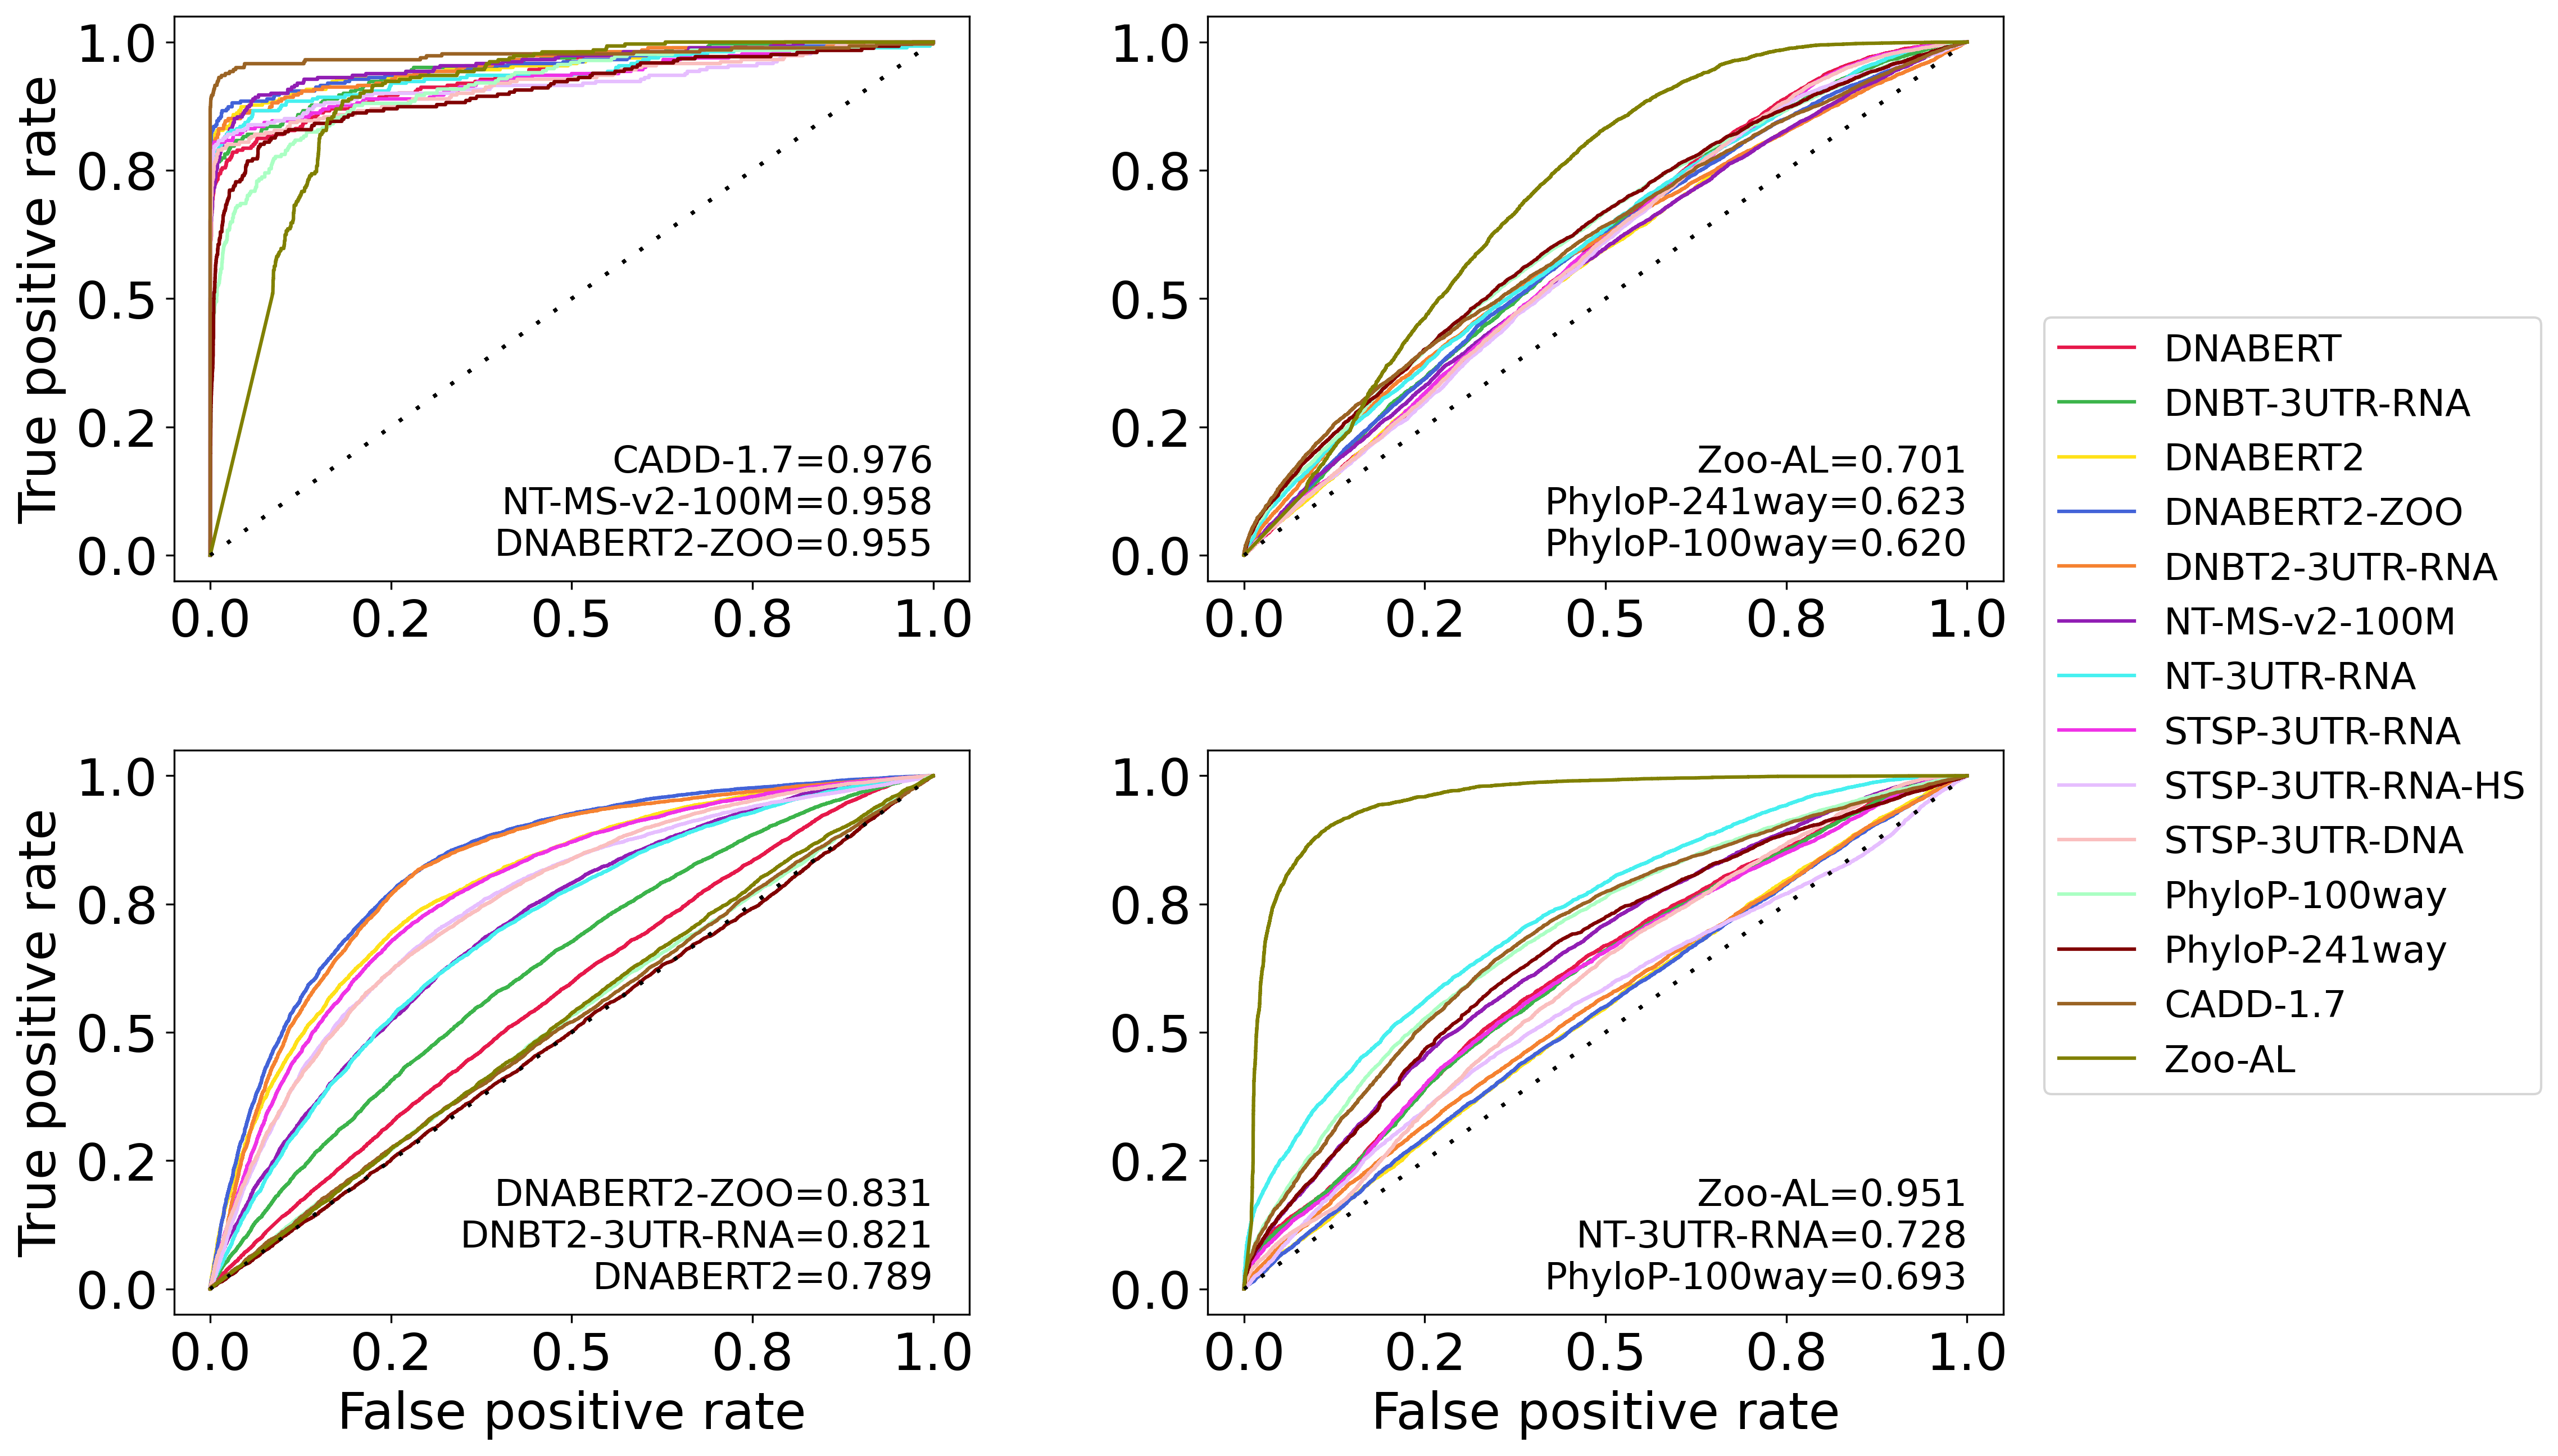

In [17]:
from matplotlib.ticker import FormatStrFormatter

matplotlib.rcParams.update({'font.size': 22})

fig, axes = plt.subplots(2,2, figsize=(14,10),dpi=300)

x = np.arange(0,1,0.01)

ax_idx = 0
for ax,split in zip(axes.flatten(),('clinvar','gnomAD','eQTL-susie','CADD')):
    ax_idx+=1
    text=[]
    for model_idx, (model,score_name) in enumerate(best_score_df.loc[split].score_name.items()):
        df = utr_variants[(utr_variants.split==split)][['label',model+'-'+score_name]].rename(columns={'label':'y_true',model+'-'+score_name:'y_pred'})
        df = df[~df.y_pred.isna()]
        fpr, tpr, _ = roc_curve(df.y_true,df.y_pred)
        if sklearn.metrics.auc(fpr,tpr)<0.5:
            fpr, tpr = tpr, fpr
        ax.plot(fpr,tpr,color=model_colors[model],label=model.replace("CADD","CADD-1.7"))
        ax.plot(x,x, linestyle=(0,(1,5)), color='k')
        ax.set_xticks([0,0.25,0.5,0.75,1])
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.set_yticks([0,0.25,0.5,0.75,1])
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    for model,auc in best_score_list.loc[split].iloc[:3].items():
        text.append(f'{model.replace("CADD","CADD-1.7")}={auc:.3f}')
    ax.text(1,0,'\n'.join(text),horizontalalignment='right',fontsize=16)
    if ax_idx==1 or ax_idx==3:
        ax.set_ylabel('True positive rate')
    if ax_idx==3 or ax_idx==4:
        ax.set_xlabel('False positive rate')
    if ax_idx==2:
        ax.legend(bbox_to_anchor=(1.7, 0.5),ncol=1, fontsize=16)

plt.subplots_adjust(wspace=0.3,hspace=0.3)

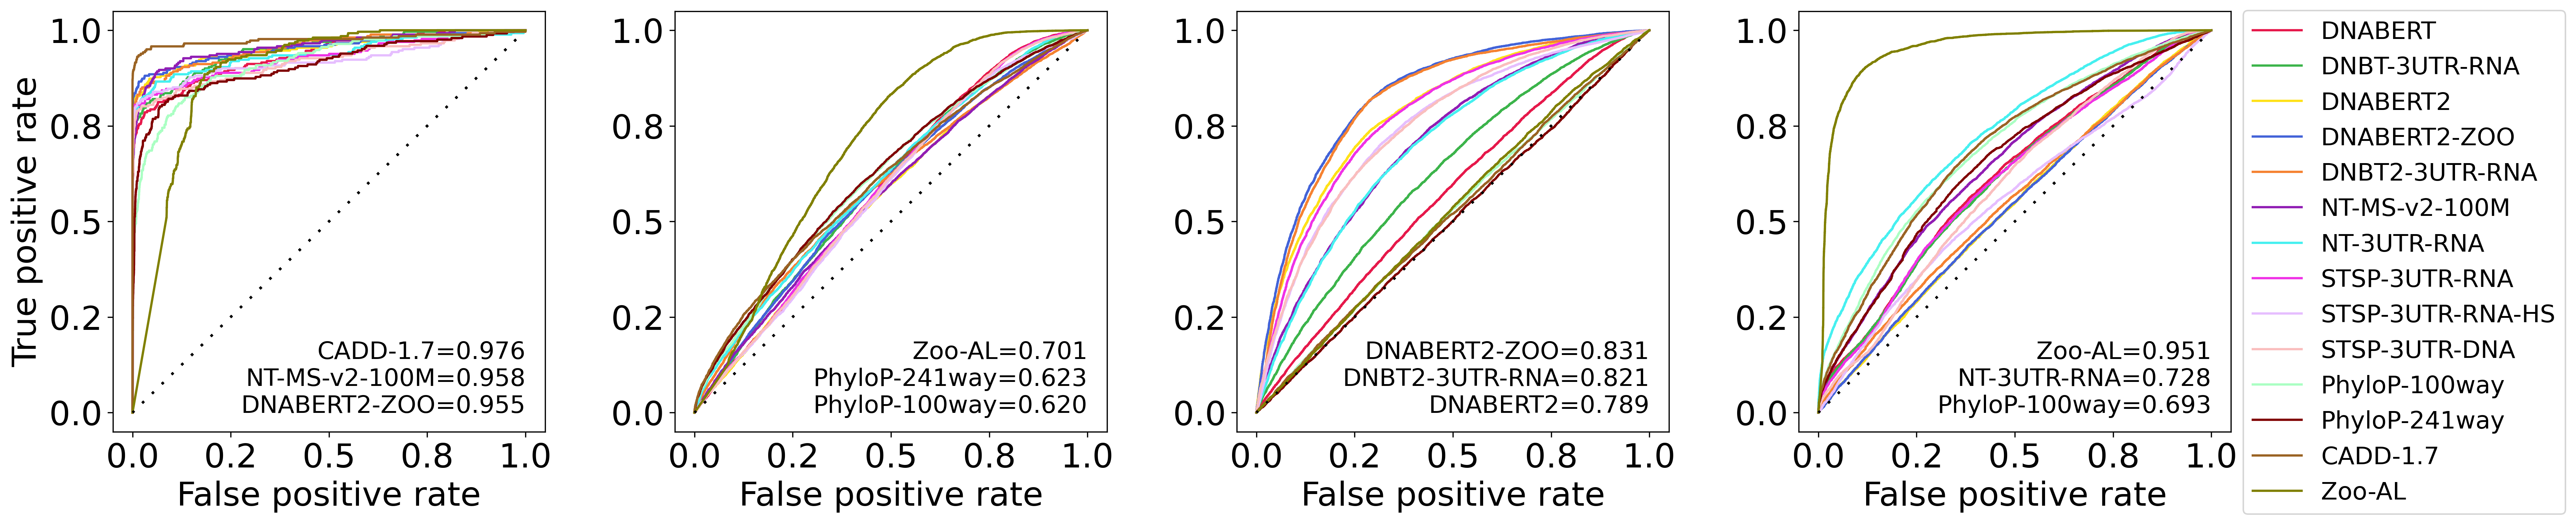

In [18]:
from matplotlib.ticker import FormatStrFormatter

matplotlib.rcParams.update({'font.size': 22})

fig, axes = plt.subplots(1,4, figsize=(25,5),dpi=300)

x = np.arange(0,1,0.01)

ax_idx = 0
for ax,split in zip(axes.flatten(),('clinvar','gnomAD','eQTL-susie','CADD')):
    ax_idx+=1
    text=[]
    for model_idx, (model,score_name) in enumerate(best_score_df.loc[split].score_name.items()):
        df = utr_variants[(utr_variants.split==split)][['label',model+'-'+score_name]].rename(columns={'label':'y_true',model+'-'+score_name:'y_pred'})
        df = df[~df.y_pred.isna()]
        fpr, tpr, _ = roc_curve(df.y_true,df.y_pred)
        if sklearn.metrics.auc(fpr,tpr)<0.5:
            fpr, tpr = tpr, fpr
        ax.plot(fpr,tpr,color=model_colors[model],label=model.replace("CADD","CADD-1.7"))
        ax.plot(x,x, linestyle=(0,(1,5)), color='k')
        ax.set_xticks([0,0.25,0.5,0.75,1])
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.set_yticks([0,0.25,0.5,0.75,1])
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    for model,auc in best_score_list.loc[split].iloc[:3].items():
        text.append(f'{model.replace("CADD","CADD-1.7")}={auc:.3f}')
    ax.text(1,0,'\n'.join(text),horizontalalignment='right',fontsize=16)
    if ax_idx==1:
        ax.set_ylabel('True positive rate')
    ax.set_xlabel('False positive rate')
    if ax_idx==4:
        ax.legend(bbox_to_anchor=(1., 1.03),ncol=1, fontsize=16)

plt.subplots_adjust(wspace=0.3,hspace=0.3)